In [1]:
# !pip install --upgrade -q  efficientnet_pytorch  \
#                            transformers \
#                            pytorch_lightning \
#                            sacrebleu \
#                            sentencepiece \ 
#                            neptune-client \
#                            datasets

In [2]:
import os
import torch
import json

from matplotlib import pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

(8, 'Tesla T4')

In [3]:
HPARAMS = {
    "name": "ocr-base-squad",
    "learning_rate": 1e-4,
    "batch_size": 5,
    "batch_accum": 2,
    "val_check_interval": 0.1,
    "limit_val_batches": 0.2,
    "patience": 10,
}

In [4]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula7/arial.ttf .

Skipping existing item: file://./arial.ttf


In [5]:
from datasets import load_dataset

squad = load_dataset('squad')

Reusing dataset squad (/home/gsurita/.cache/huggingface/datasets/squad/plain_text/1.0.0/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41)


In [6]:
import textwrap
import numpy as np

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

from matplotlib.pyplot import imshow


def text_to_image(text: str, max_width: int, max_height: int, ):

    font_size = np.random.randint(12, 13)
    font = ImageFont.truetype("arial.ttf", font_size)
    
    image = Image.new('RGB', (max_width, max_height), (255, 255, 255))  # white background.
    d = ImageDraw.Draw(image)
    
    left_border = np.random.randint(4, 6)
    top_border = np.random.randint(1, 2)
    
#     wraps = textwrap.wrap(text, width=(3400 - left_border) // font_size)
    
    d.text((left_border, top_border), text, font=font, fill=(0, 0, 0))
#     for col, wrap in enumerate(wraps): 
#         d.text((left_border, top_border + 1.2 * font_size * col), wrap, font=font, fill=(0, 0, 0))
    
    text_width, text_height = d.textsize(text)  # Caso queria saber o tamanho do texto.
    
    # random_rotation = np.random.uniform(-.1, .1)
    
    # image = image.rotate(random_rotation, expand=0, fillcolor=(255, 255, 255))

    arr = np.array(image).astype(np.int)
    arr += np.random.uniform(-30, 30, size=arr.shape).astype(np.int)
    
    return arr.clip(0, 255).astype(np.uint8)

[nltk_data] Downloading package punkt to /home/gsurita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


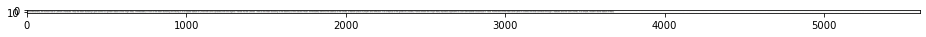

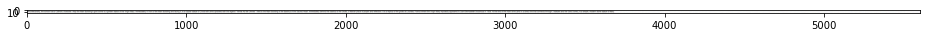

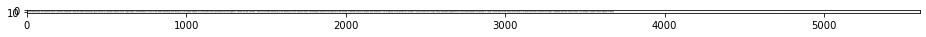

In [7]:
import re
import nltk

nltk.download("punkt")


text = squad["train"][0]["context"]

for i in range(3):
    image = text_to_image(text=text.encode("latin-1", "ignore").decode("latin-1"), max_width=5600, max_height=16)
    plt.figure(figsize = (16,16))
    imshow(image)
    plt.show()

In [8]:
squad["train"][0]

{'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']},
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'id': '5733be284776f41900661182',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'title': 'University_of_Notre_Dame'}

In [9]:
import random
import json
import h5py

import regex
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# Normalization suggested by the EfficientNet library when trained with adversarial examples.
# https://github.com/lukemelas/EfficientNet-PyTorch#update-january-23-2020
transform = transforms.Compose([
    transforms.Lambda(lambda img: img * 2.0  - 1.0),
])


class VQADataset(Dataset):

    def __init__(self, data, img_transform=lambda x: x):        
        self.data = data
        self.img_transform = img_transform

    def __len__(self):
        # 10 % of the samples are blank.
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]

        context = item["context"]
        question = item["question"]
        answer = item["answers"]["text"][0] if item["answers"]["text"] else ""
        
        context_clean = context.encode("latin-1", "ignore").decode("latin-1")
        img = text_to_image(text=context_clean, max_width=6400, max_height=16)

        # Convert to float.
        img = np.moveaxis(img, 2, 0).astype(float)

        # Normalize image between 0 and 1.
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
                
        return self.img_transform(img), question, answer
    

train_set = VQADataset(squad["train"], img_transform=transform)
val_set = VQADataset(squad["validation"], img_transform=transform)

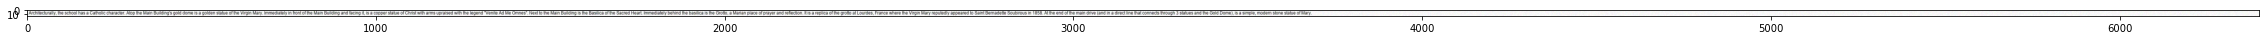

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Saint Bernadette Soubirous


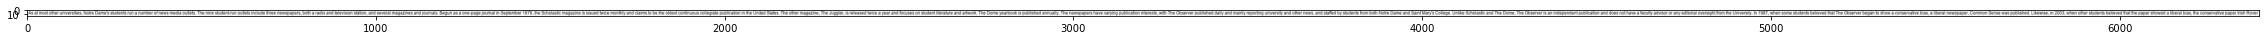

How many student news papers are found at Notre Dame?
three


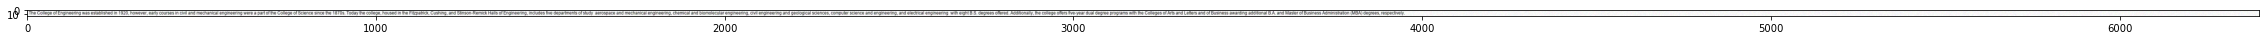

In what year was the College of Engineering at Notre Dame formed?
1920


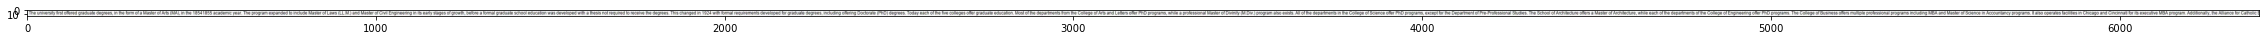

The granting of Doctorate degrees first occurred in what year at Notre Dame?
1924


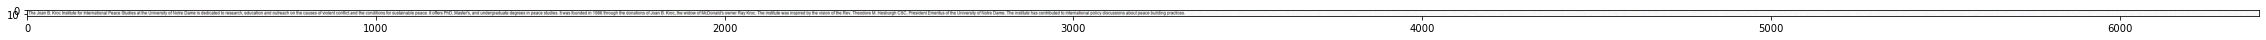

To whom was John B. Kroc married?
Ray Kroc


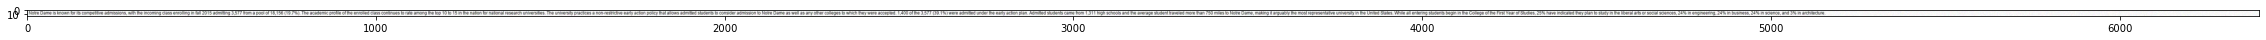

What percentage of students were admitted to Notre Dame in fall 2015?
19.7%


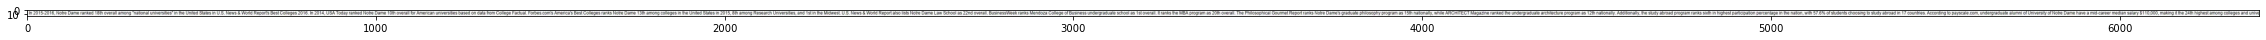

What percentage of Notre Dame students decide to study abroad?
57.6%


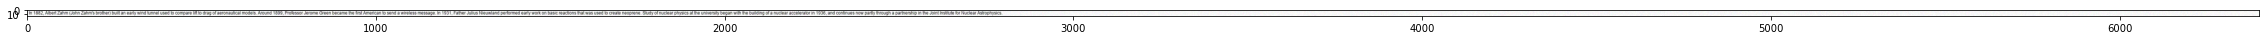

In what year did Jerome Green send his first wireless message?
Around 1899


In [10]:
for (img, question, answer), i in zip(train_set, range(64)):
    if i % 8 != 0:
        continue
    
    norm_img = (img + 1) / 2.

    plt.figure(figsize = (40, 2))
    plt.imshow(np.moveaxis(norm_img, 0, 2))
    plt.show()
    
    print(question)
    print(answer)

In [11]:
from transformers import T5ForConditionalGeneration, T5Tokenizer


tokenizer = T5Tokenizer.from_pretrained('t5-base')


def collate_fn(batch):
    """
    Input any (selected randomly) caption sample for every image. Useful for training.
    """
    
    imgs = [r[0] for r in batch]
    questions = [r[1] for r in batch]
    answers = [r[2] for r in batch]
    
    question_tokens = tokenizer.batch_encode_plus(questions, return_tensors="pt", padding="longest")
    answer_tokens = tokenizer.batch_encode_plus(answers, return_tensors="pt", padding="longest")

    return (
        torch.tensor(imgs, dtype=torch.float), 
        question_tokens["input_ids"], 
        answer_tokens["input_ids"], 
        questions,
        answers,
    )

In [12]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer


import numpy as np
import sacrebleu
import pytorch_lightning as pl



class VQAModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.decoder = T5ForConditionalGeneration.from_pretrained('t5-base')
        
        # Patch convolution. Basically tranform the 2D image into 16x16 patches with 2048 dimensions.
        self.patch = nn.Conv2d(in_channels=3, out_channels=self.decoder.config.d_model, kernel_size=16, stride=16) # , padding=4)
        
        # Convert patches from 2048 to 512 dimensions.
        self.linear = nn.Linear(self.decoder.config.d_model, self.decoder.config.d_model)
        
        # Embedding to describe data type.
        self.dtype_embedding = nn.Embedding(2, self.decoder.config.d_model)
        
        self.txt_pos_embedding = nn.Embedding(2048, self.decoder.config.d_model)
        self.img_pos_embedding = nn.Embedding(2048, self.decoder.config.d_model)
        
    def _embeds_forward(self, img, question):
        
        # Compute patches to feed the transformer.
        features = self.patch(img)

        # Reshape the output to the 2D format of the tranformer.
        img_inputs = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        img_pos_emb = self.img_pos_embedding(torch.arange(img_inputs.size(1), device=img.device)).unsqueeze(0)
        img_inputs = img_inputs + img_pos_emb + self.dtype_embedding._parameters["weight"][0]
        
        txt_pos_emb = self.txt_pos_embedding(torch.arange(question.size(1), device=img.device)).unsqueeze(0)
        txt_inputs = self.decoder.shared(question) + txt_pos_emb + self.dtype_embedding._parameters["weight"][1] 
        
        return torch.cat([txt_inputs, img_inputs], dim=1)

    def forward(self, imgs=None, questions=None, inputs_embeds=None, decoder_input_ids=None, labels=None):

        # Pass efficientnet hidden states as embeddings for the transformer encoder input.
        inputs_embeds = (
            self._embeds_forward(imgs, questions)
            if inputs_embeds is None else inputs_embeds
        )
        
        return self.decoder(
            inputs_embeds=inputs_embeds,
            decoder_input_ids=decoder_input_ids, 
            labels=labels,
        )

    def generate(self, img, question, max_len=128):

        # We need to implement our own generate loop as transformers doesn't accept 
        # precomputed embeddings on the generate method.
        # Issue: https://github.com/huggingface/transformers/issues/7626
        
        # Precompute embeddings to speedup generation as they don't change.
        inputs_embeds = self._embeds_forward(img, question)

        decoder_input_ids = torch.full(
            (1, 1), self.decoder.config.decoder_start_token_id, dtype=torch.long, device=img.device
        )

        for i in range(max_len):
            with torch.no_grad():
                output = self.forward(decoder_input_ids=decoder_input_ids, 
                                      inputs_embeds=inputs_embeds)
            
            logits = output[0]
            next_token_logits = logits[:, -1, :]
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1).to(img.device)

            if torch.eq(next_token_id[:, -1], self.decoder.config.eos_token_id).all():
                break

        return decoder_input_ids

    def training_step(self, batch, batch_idx):
        imgs, questions, targets, raw_questions, raw_answers = batch
        output = self(imgs, questions, labels=targets)
        loss = output[0]
        self.log("train_loss", loss.cpu().item())

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, questions, targets, raw_questions, raw_answers = batch
        tokens = [self.generate(im.view((1,) + im.shape), questions)[0].cpu() for im in imgs]
        
        return (tokens, raw_questions, raw_answers)

    def validation_epoch_end(self, validation_step_outputs):
        validation_step_outputs = list(validation_step_outputs)
    
        tokens_batch = [t for out in validation_step_outputs for t in out[0]]
        reference_batch = [r for out in validation_step_outputs for r in out[2]]
        
        generated_batch = tokenizer.batch_decode(tokens_batch)
        
        bleu = sacrebleu.corpus_bleu(generated_batch, [reference_batch])
        
        em = np.average([compute_exact(g, r) for g, r in zip(generated_batch, reference_batch)])
        f1 = np.average([compute_f1(g, r) for g, r in zip(generated_batch, reference_batch)])
        
        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_exact_match", em, prog_bar=True)
        self.log("val_word_f1", f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, questions, targets, raw_questions, raw_answers = batch
        tokens = [self.generate(im.view((1,) + im.shape), questions)[0].cpu() for im in imgs]
        
        return (tokens, raw_questions, raw_answers)
    
    def test_epoch_end(self, validation_step_outputs):
        validation_step_outputs = list(validation_step_outputs)
    
        tokens_batch = [t for out in validation_step_outputs for t in out[0]]
        reference_batch = [r for out in validation_step_outputs for r in out[2]]
        
        generated_batch = tokenizer.batch_decode(tokens_batch)
        
        bleu = sacrebleu.corpus_bleu(generated_batch, [reference_batch])
        
        em = np.average([compute_exact(g, r) for g, r in zip(generated_batch, reference_batch)])
        f1 = np.average([compute_f1(g, r) for g, r in zip(generated_batch, reference_batch)])
        
        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_exact_match", em, prog_bar=True)
        self.log("test_word_f1", f1, prog_bar=True)
        
        return {
            "test_bleu_score": bleu.score,
            "test_bleu_1": bleu.precisions[0],
            "test_bleu_4": bleu.precisions[3],
            "test_exact_match": em,
            "test_word_f1": f1,
        }
        
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=HPARAMS["learning_rate"])

In [14]:
model = VQAModule()
model = model.load_from_checkpoint("./logs/ocr-base-long-epoch=1-val_word_f1=0.88-v0.ckpt")


In [15]:
import os
import pytorch_lightning as pl
from transformers import T5ForConditionalGeneration, T5Tokenizer


batch_size = HPARAMS["batch_size"]
name = HPARAMS["name"]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=1, num_workers=os.cpu_count(), collate_fn=collate_fn)

# Log results to CSV (so we can plot them later).
csv_logger = pl.loggers.csv_logs.CSVLogger(f"./logs", name=name)

# Log results to Neptune.
neptune_logger = pl.loggers.neptune.NeptuneLogger(
    api_key="",
    project_name=f"gabisurita/{name}",
    params=HPARAMS,
)

# Early stop if val BLEU score doesnt increase for 10 epochs.
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_word_f1', patience=HPARAMS["patience"], mode='max')

# Checkpoint the best model.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    prefix=name,
    filepath="logs/{epoch}-{val_word_f1:.2f}", 
    monitor="val_word_f1", 
    mode="max",
)


trainer = pl.Trainer(
    gpus=1,  
    logger=[csv_logger, neptune_logger],
    callbacks=[early_stop_callback],
    checkpoint_callback=checkpoint_callback, 
    
    accumulate_grad_batches=HPARAMS["batch_accum"],
    # Run validation over a smaller sample.
    val_check_interval=HPARAMS["val_check_interval"],
    limit_val_batches=HPARAMS["limit_val_batches"],
)

https://ui.neptune.ai/gabisurita/ocr-base-squad/e/OC1-17


NeptuneLogger will work in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model, train_loader, val_loader)


  | Name              | Type                       | Params
-----------------------------------------------------------------
0 | decoder           | T5ForConditionalGeneration | 222 M 
1 | patch             | Conv2d                     | 590 K 
2 | linear            | Linear                     | 590 K 
3 | dtype_embedding   | Embedding                  | 1.5 K 
4 | txt_pos_embedding | Embedding                  | 1.6 M 
5 | img_pos_embedding | Embedding                  | 1.6 M 


Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

Failed to send channel value.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/opt/conda/lib/python3.7/site-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC1-17. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: f8d9c7bd-0485-4bae-8510-2ba5e8578436

In [ ]:
_ = model.cpu()
_ = model.eval()

In [ ]:
from matplotlib import pyplot as plt
import cv2




for batch, i in zip(val_loader, range(16)):
        
    imgs, questions, targets, raw_questions, raw_answers = batch

    for (img, q, a) in zip(imgs, questions, targets):
        norm_img = (img.numpy() + 1) / 2.
        
        plt.figure(figsize = (20,20))
        plt.imshow(np.moveaxis(norm_img, 0, 2))
        plt.show()
        tokens = model.generate(img.view((1,) + img.shape), q.view((1,) + q.shape))
        
        print(raw_questions[0])
        print(tokenizer.batch_decode(tokens)[0])
        print(raw_answers[0])
        print()